# BMW Sales Analysis (2010–2024)

This notebook performs a structured time-series exploration and baseline forecasting for the dataset `BMW sales data (2010-2024) (1).csv` following the outlined 14 sections. Run cells in order.

---
## 1. Import Libraries and Notebook Settings


In [6]:
# 1. Import Libraries and Notebook Settings
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_theme(style='whitegrid')

# Optional: statsmodels for decomposition and Holt-Winters
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False
    print("Note: statsmodels not available; decomposition and Holt-Winters forecast cells will be skipped.")

Note: statsmodels not available; decomposition and Holt-Winters forecast cells will be skipped.


In [7]:
# 2. Load Dataset from CSV
# Try to locate the CSV relative to this notebook workspace.
CANDIDATE_PATHS = [
    Path.cwd() / "BMW sales data (2010-2024) (1).csv",
]
CSV_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        CSV_PATH = p
        break

if CSV_PATH is None:
    raise FileNotFoundError("Could not find 'BMW sales data (2010-2024) (1).csv' in the current folder.")

# Load without forcing parse; we may parse dates after normalizing columns.
df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()
print('Loaded:', CSV_PATH)
display(df.head())
print('Shape:', df.shape)

Loaded: c:\Users\ajmcs\OneDrive\VSCODE School Projects\25-26Q1\Jupyter\BMW sales data (2010-2024) (1).csv


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


Shape: (50000, 11)


In [8]:
# 3. Inspect DataFrame Structure
print('Columns:', list(df.columns))
print('\nDtypes:')
print(df.dtypes)
print('\nNulls per column:')
print(df.isna().sum())
print('\nDuplicate rows:', df.duplicated().sum())

print('\nHead:')
display(df.head())
print('\nTail:')
display(df.tail())

print('\nDescribe (numeric):')
display(df.describe())

Columns: ['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification']

Dtypes:
Model                    object
Year                      int64
Region                   object
Color                    object
Fuel_Type                object
Transmission             object
Engine_Size_L           float64
Mileage_KM                int64
Price_USD                 int64
Sales_Volume              int64
Sales_Classification     object
dtype: object

Nulls per column:
Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

Duplicate rows: 0

Head:


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low



Tail:


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
49995,i3,2014,Asia,Red,Hybrid,Manual,4.6,151030,42932,8182,High
49996,i3,2023,Middle East,Silver,Electric,Manual,4.2,147396,48714,9816,High
49997,5 Series,2010,Middle East,Red,Petrol,Automatic,4.5,174939,46126,8280,High
49998,i3,2020,Asia,White,Electric,Automatic,3.8,3379,58566,9486,High
49999,X1,2020,North America,Blue,Diesel,Manual,3.3,171003,77492,1764,Low



Describe (numeric):


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [9]:
# 4. Clean and Normalize Columns
# Standardize column names to snake_case
original_cols = list(df.columns)
rename_map = {}
for c in original_cols:
    new_c = c.strip().lower().replace(' ', '_').replace('-', '_')
    rename_map[c] = new_c

df.rename(columns=rename_map, inplace=True)

# Trim string columns
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip()

# Attempt harmonization of known fields
possible_date_cols = [col for col in df.columns if 'date' in col or 'year' in col or 'month' in col]
possible_sales_cols = [col for col in df.columns if 'sale' in col or 'units' in col or 'volume' in col]
print('Candidate date-related columns:', possible_date_cols)
print('Candidate sales-related columns:', possible_sales_cols)

# Drop exact duplicates
before = len(df)
df.drop_duplicates(inplace=True)
print('Dropped', before - len(df), 'duplicate rows')

display(df.head())

Candidate date-related columns: ['year']
Candidate sales-related columns: ['sales_volume', 'sales_classification']
Dropped 0 duplicate rows
Dropped 0 duplicate rows


,model,year,region,color,fuel_type,transmission,engine_size_l,mileage_km,price_usd,sales_volume,sales_classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [11]:
# 5. Coerce Types and Parse Dates
import re

# Coerce numerics where possible (non-key columns)
for c in df.columns:
    if c not in ('date', 'year', 'month', 'model', 'region'):
        try:
            df[c] = pd.to_numeric(df[c], errors='ignore')
        except Exception:
            pass

# Identify candidate columns

def find_col(patterns):
    for pat in patterns:
        rgx = re.compile(pat, flags=re.I)
        for c in df.columns:
            if rgx.search(c):
                return c
    return None

col_date = find_col([r'^date$', r'^period$', r'^month_year$'])
col_year = find_col([r'^year$'])
col_month = find_col([r'^month$'])
col_sales = find_col([r'^sales$', r'units', r'volume', r'registrations'])
col_model = find_col([r'^model$', r'series'])
col_region = find_col([r'region', r'country', r'market'])

# Standardize names
rename = {}
if col_date and col_date != 'date':
    rename[col_date] = 'date'
if col_year and col_year != 'year':
    rename[col_year] = 'year'
if col_month and col_month != 'month':
    rename[col_month] = 'month'
if col_sales and col_sales != 'sales':
    rename[col_sales] = 'sales'
if col_model and col_model != 'model':
    rename[col_model] = 'model'
if col_region and col_region != 'region':
    rename[col_region] = 'region'
if rename:
    df.rename(columns=rename, inplace=True)

# Build/parse a proper date column
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
elif 'year' in df.columns and 'month' in df.columns:
    # Map month strings to month numbers if needed
    month_map = {name.lower(): i for i, name in enumerate(
        ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], start=1)}

    def parse_month(m):
        s = str(m).strip()
        try:
            v = int(float(s))
            if 1 <= v <= 12:
                return v
        except Exception:
            pass
        s_low = s.lower()
        for k, v in month_map.items():
            if s_low.startswith(k[:3].lower()):
                return v
        return np.nan

    mnum = df['month'].apply(parse_month)
    df['date'] = pd.to_datetime(
        dict(year=pd.to_numeric(df['year'], errors='coerce'), month=mnum.astype('Int64'), day=1),
        errors='coerce'
    )
elif 'year' in df.columns:
    # Year only -> default to January 1st of that year
    try:
        y = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
        df['date'] = pd.to_datetime(y.astype(str), format='%Y', errors='coerce')
    except Exception:
        df['date'] = pd.to_datetime(df['year'], errors='coerce', infer_datetime_format=True)
else:
    # Fallback: try parse any object column as date if >50% non-null parsable
    parsed = None
    for c in df.columns:
        if df[c].dtype == object:
            cand = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True, dayfirst=True)
            if cand.notna().mean() > 0.5:
                parsed = cand
                break
    if parsed is not None:
        df['date'] = parsed

# Ensure `sales` column exists and numeric
if 'sales' not in df.columns:
    cand_sales = [c for c in df.columns if re.search(r'sales|units|volume|registrations', c, flags=re.I)]
    if cand_sales:
        df['sales'] = pd.to_numeric(df[cand_sales[0]], errors='coerce')

print('Columns after standardization:', list(df.columns))
cols_to_show = [c for c in ['date', 'sales', 'year', 'month', 'model', 'region'] if c in df.columns]
print(df[cols_to_show].head())

Columns after standardization: ['model', 'year', 'region', 'color', 'fuel_type', 'transmission', 'engine_size_l', 'mileage_km', 'price_usd', 'sales', 'sales_classification', 'date']
        date  sales  year     model         region
0 2016-01-01   8300  2016  5 Series           Asia
1 2013-01-01   3428  2013        i8  North America
2 2022-01-01   6994  2022  5 Series  North America
3 2024-01-01   4047  2024        X3    Middle East
4 2020-01-01   3080  2020  7 Series  South America


In [12]:
# 6. Time-Based Indexing and Resampling
# Set datetime index, drop rows without a valid date
valid_date_mask = df['date'].notna()
invalid_rows = (~valid_date_mask).sum()
if invalid_rows:
    print(f'Dropping {invalid_rows} rows without valid date')

df = df.loc[valid_date_mask].copy()

df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# Ensure sales numeric
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')

# Monthly resample (start of month)
monthly = df['sales'].resample('MS').sum().to_frame(name='sales')
quarterly = df['sales'].resample('QS').sum().to_frame(name='sales')
yearly = df['sales'].resample('YS').sum().to_frame(name='sales')

print('Monthly shape:', monthly.shape)
print('Quarterly shape:', quarterly.shape)
print('Yearly shape:', yearly.shape)

monthly.head()

Monthly shape: (169, 1)
Quarterly shape: (57, 1)
Yearly shape: (15, 1)


,sales
date,
2010-01-01,16933445
2010-02-01,0
2010-03-01,0
2010-04-01,0
2010-05-01,0


In [13]:
# 7. Feature Engineering: Rolling Stats and Growth Rates
mfe = monthly.copy()
mfe['roll3'] = mfe['sales'].rolling(3).mean()
mfe['roll6'] = mfe['sales'].rolling(6).mean()
mfe['roll12'] = mfe['sales'].rolling(12).mean()
mfe['roll3_std'] = mfe['sales'].rolling(3).std()
mfe['cum_sales'] = mfe['sales'].cumsum()
mfe['mom'] = mfe['sales'].pct_change()  # Month-over-Month
mfe['yoy'] = mfe['sales'].pct_change(12)  # Year-over-Year
mfe['log_sales'] = np.log1p(mfe['sales'])

mfe.tail()

,sales,roll3,roll6,roll12,roll3_std,cum_sales,mom,yoy,log_sales
date,,,,,,,,,
2023-09-01,0,0.0,0.0,1.355721e+06,0.000000e+00,235847880,NaN,NaN,0.000000
2023-10-01,0,0.0,0.0,1.355721e+06,0.000000e+00,235847880,NaN,NaN,0.000000
2023-11-01,0,0.0,0.0,1.355721e+06,0.000000e+00,235847880,NaN,NaN,0.000000
2023-12-01,0,0.0,0.0,1.355721e+06,0.000000e+00,235847880,NaN,NaN,0.000000
2024-01-01,17527854,5842618.0,2921309.0,1.460654e+06,1.011971e+07,253375734,inf,0.0774,16.679302


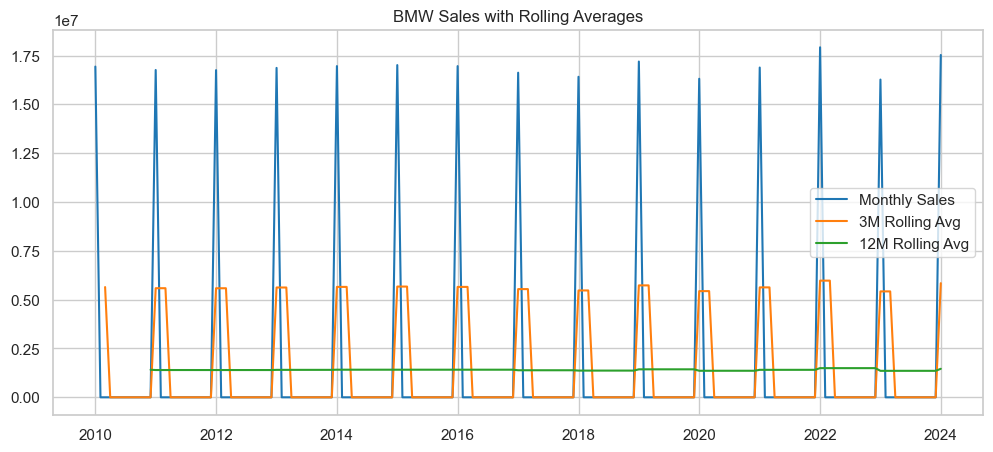

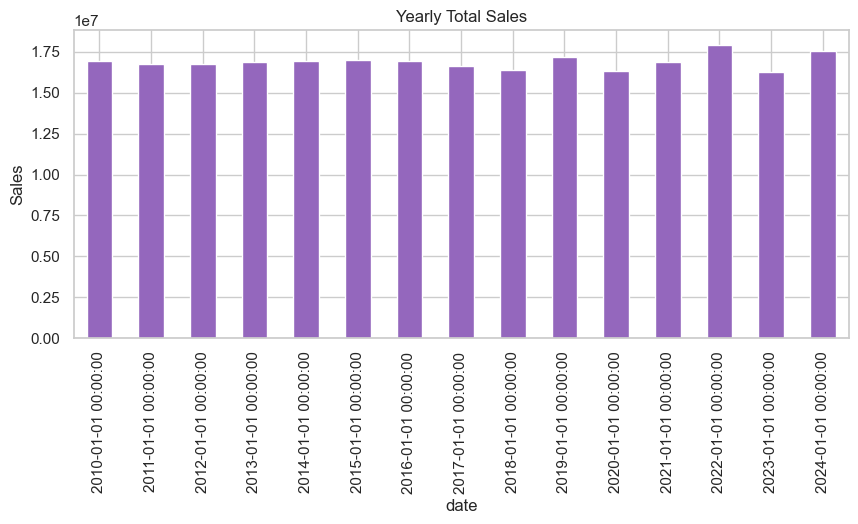

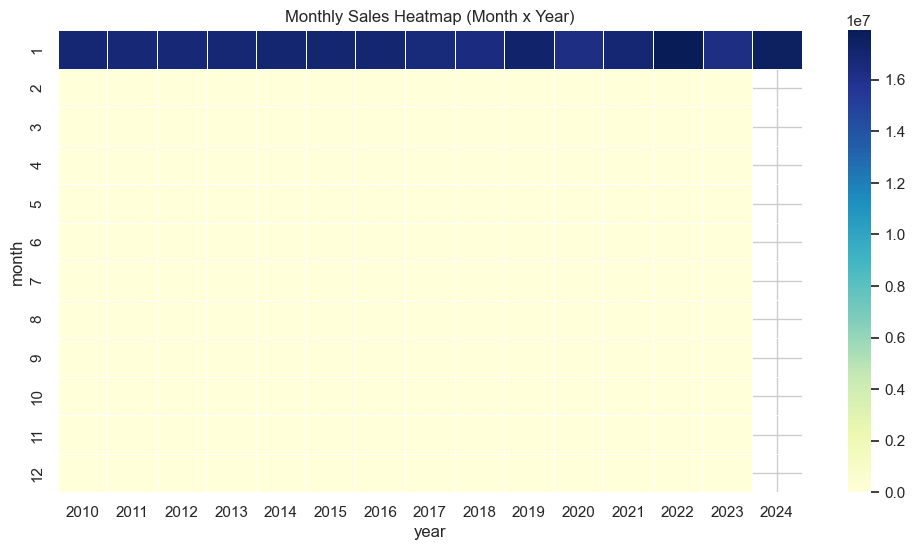

In [21]:
# 8. Visualize Trends and Seasonality
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['sales'], label='Monthly Sales', color='tab:blue')
plt.plot(mfe.index, mfe['roll3'], label='3M Rolling Avg', color='tab:orange')
plt.plot(mfe.index, mfe['roll12'], label='12M Rolling Avg', color='tab:green')
plt.title('BMW Sales with Rolling Averages')
plt.legend()
plt.show()

# Yearly totals bar chart
year_totals = yearly['sales']
plt.figure(figsize=(10,4))
year_totals.plot(kind='bar', color='tab:purple')
plt.title('Yearly Total Sales')
plt.ylabel('Sales')
plt.show()

# Heatmap month x year (if monthly spans multiple years)
heat = monthly.copy()
heat['year'] = heat.index.year
heat['month'] = heat.index.month
pivot = heat.pivot_table(index='month', columns='year', values='sales', aggfunc='sum')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=.5, annot=False)
plt.title('Monthly Sales Heatmap (Month x Year)')
plt.show()

Outliers detected: 15


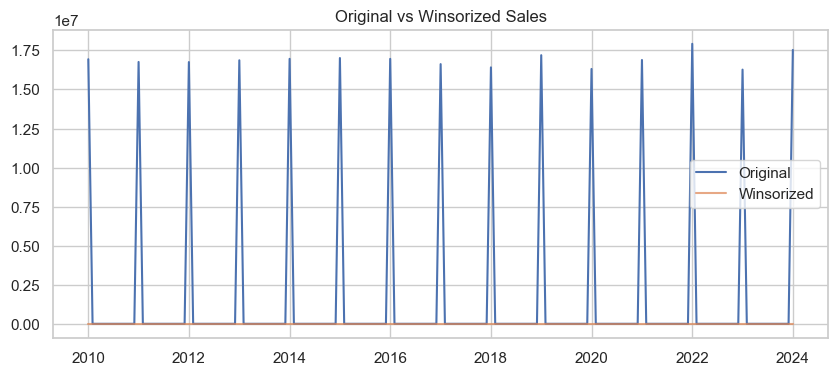

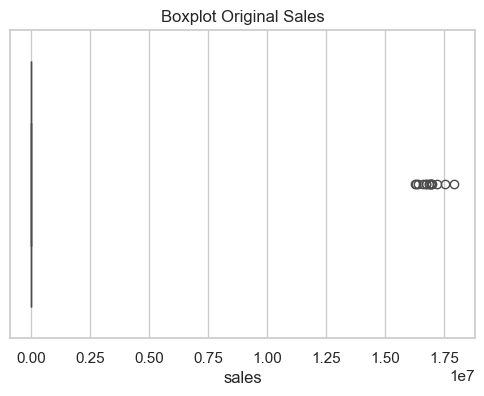

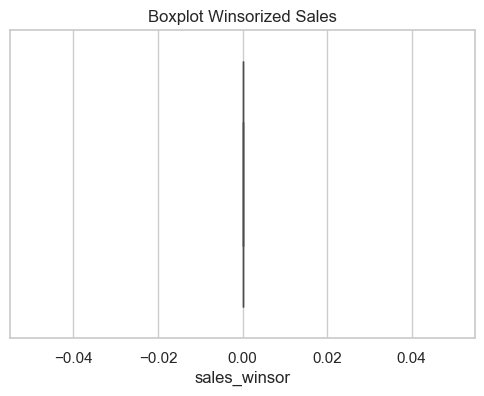

In [22]:
# 9. Detect and Treat Outliers (IQR method)
vals = monthly['sales']
Q1 = vals.quantile(0.25)
Q3 = vals.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (vals < lower_bound) | (vals > upper_bound)
print('Outliers detected:', outlier_mask.sum())

# Optionally winsorize extreme values
df_out = monthly.copy()
cap_low = max(lower_bound, 0)
df_out['sales_winsor'] = df_out['sales'].clip(lower=cap_low, upper=upper_bound)

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly['sales'], label='Original')
plt.plot(df_out.index, df_out['sales_winsor'], label='Winsorized', alpha=0.7)
plt.title('Original vs Winsorized Sales')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=monthly['sales'])
plt.title('Boxplot Original Sales')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_out['sales_winsor'])
plt.title('Boxplot Winsorized Sales')
plt.show()

In [23]:
# 10. Seasonal Decomposition (additive, period=12)
if HAS_STATSMODELS:
    series = monthly['sales'].astype(float).interpolate(limit_direction='both')
    if series.dropna().shape[0] >= 24:
        decomp = seasonal_decompose(series, model='additive', period=12)
        fig = decomp.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle('Seasonal Decomposition (Additive, period=12)', y=1.02)
        plt.show()
    else:
        print('Not enough data points for seasonal decomposition (need >= 24 months).')
else:
    print('statsmodels not available; skipping decomposition.')

statsmodels not available; skipping decomposition.


In [24]:
# 11. Train/Test Split and Baseline Forecast (Holt-Winters)
if HAS_STATSMODELS:
    series = monthly['sales'].astype(float).interpolate(limit_direction='both')
    horizon = 12 if series.shape[0] > 24 else max(1, series.shape[0] // 4)
    train = series.iloc[:-horizon]
    test = series.iloc[-horizon:]
    print(f'Train length: {train.shape[0]}, Test length: {test.shape[0]}')
    
    try:
        model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
        fitted = model.fit(optimized=True)
        forecast = fitted.forecast(horizon)
        # Evaluation metrics
        df_eval = pd.DataFrame({'actual': test, 'forecast': forecast})
        mae = np.mean(np.abs(df_eval['actual'] - df_eval['forecast']))
        mape = np.mean(np.abs((df_eval['actual'] - df_eval['forecast']) / df_eval['actual'])) * 100
        rmse = np.sqrt(np.mean((df_eval['actual'] - df_eval['forecast']) ** 2))
        print(f'MAE: {mae:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')
        
        plt.figure(figsize=(12,5))
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Actual Test', color='black')
        plt.plot(forecast.index, forecast, label='Forecast', color='red')
        plt.title('Holt-Winters Forecast vs Actual')
        plt.legend()
        plt.show()
    except Exception as e:
        print('Forecasting failed:', e)
else:
    print('statsmodels not available; skipping Holt-Winters forecast.')

statsmodels not available; skipping Holt-Winters forecast.


Top models by total sales:


model
7 Series    23786466
i8          23423891
X1          23406060
3 Series    23281303
i3          23133849
Name: sales, dtype: int64

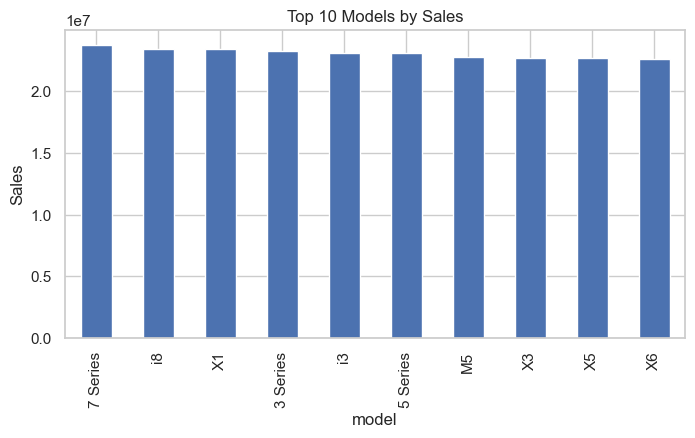

Top regions by total sales:


region
Asia             42974277
Europe           42555138
North America    42402629
Middle East      42326620
Africa           41565252
Name: sales, dtype: int64

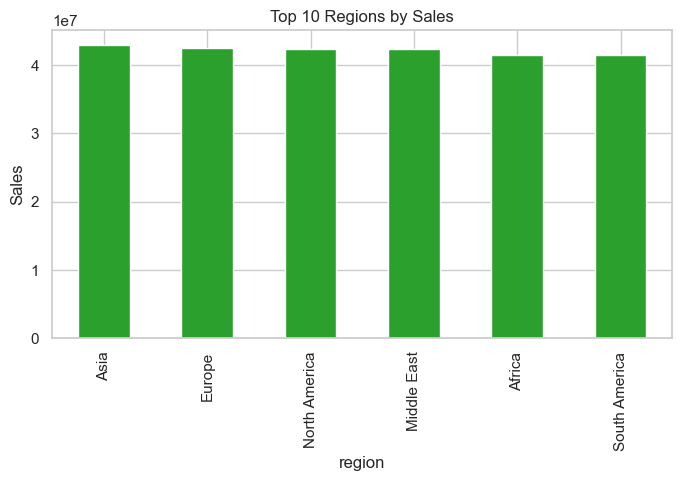

YoY growth per model (annual):


model,3 Series,5 Series,7 Series,M3,M5,X1,X3,X5,X6,i3,i8
date,,,,,,,,,,,
2020-01-01,0.053233,-0.043938,0.069982,0.035058,-0.097261,-0.037435,-0.074183,-0.113113,-0.118711,-0.167405,-0.028483
2021-01-01,0.027141,-0.113830,0.052436,0.064182,0.124046,-0.067071,0.081542,-0.036446,0.082775,0.179178,0.019914
2022-01-01,0.014257,0.172149,0.070580,0.092306,-0.100346,0.025111,0.082923,0.258696,0.089393,-0.060298,0.082097
2023-01-01,-0.056899,-0.112197,-0.089332,-0.078901,-0.036997,-0.058666,-0.045198,-0.285120,-0.085362,-0.105125,-0.034905
2024-01-01,0.000532,0.213297,0.064628,-0.150894,0.115927,0.025005,0.084397,0.135574,0.179871,0.181266,0.033551


YoY growth per region (annual):


region,Africa,Asia,Europe,Middle East,North America,South America
date,,,,,,
2020-01-01,-0.000131,-0.112814,-0.092253,0.104954,-0.107537,-0.081290
2021-01-01,0.042517,0.131047,0.047262,-0.001748,-0.019010,0.025344
2022-01-01,0.012287,0.100332,0.032068,0.014266,0.105062,0.113249
2023-01-01,-0.075891,-0.113008,-0.098475,-0.073409,-0.034663,-0.157349
2024-01-01,0.045967,0.159273,0.107254,0.069286,-0.016942,0.109857


In [25]:
# 12. Conditional Grouped Analysis (Model / Region)
if 'model' in df.columns:
    model_group = df.groupby('model')['sales'].sum().sort_values(ascending=False)
    print('Top models by total sales:')
    display(model_group.head())
    plt.figure(figsize=(8,4))
    model_group.head(10).plot(kind='bar')
    plt.title('Top 10 Models by Sales')
    plt.ylabel('Sales')
    plt.show()

if 'region' in df.columns:
    region_group = df.groupby('region')['sales'].sum().sort_values(ascending=False)
    print('Top regions by total sales:')
    display(region_group.head())
    plt.figure(figsize=(8,4))
    region_group.head(10).plot(kind='bar', color='tab:green')
    plt.title('Top 10 Regions by Sales')
    plt.ylabel('Sales')
    plt.show()

# Per-group YoY growth if possible
if 'model' in df.columns:
    # Build a monthly pivot per model
    m_model = df.groupby(['model']).resample('YS')['sales'].sum().unstack(level=0)
    yoy_model = m_model.pct_change()
    print('YoY growth per model (annual):')
    display(yoy_model.tail())

if 'region' in df.columns:
    m_region = df.groupby(['region']).resample('YS')['sales'].sum().unstack(level=0)
    yoy_region = m_region.pct_change()
    print('YoY growth per region (annual):')
    display(yoy_region.tail())

In [26]:
# 13. Export Cleaned Data and Artifacts
out_csv = Path.cwd() / 'bmw_sales_clean.csv'
mfe.to_csv(out_csv, index=True)
print('Wrote cleaned monthly series with features to:', out_csv)

# Optionally save figures: uncomment below and re-run plotting cells to save to disk
# fig_path = Path.cwd() / 'bmw_sales_trends.png'
# plt.figure(figsize=(12,5))
# plt.plot(monthly.index, monthly['sales'], label='Monthly Sales', color='tab:blue')
# plt.plot(mfe.index, mfe['roll12'], label='12M Rolling Avg', color='tab:green')
# plt.legend(); plt.title('BMW Sales Trends')
# plt.savefig(fig_path, bbox_inches='tight'); plt.close(); print('Saved figure:', fig_path)

Wrote cleaned monthly series with features to: c:\Users\ajmcs\OneDrive\VSCODE School Projects\25-26Q1\Jupyter\bmw_sales_clean.csv


In [28]:
# 14. Lightweight Data Validation Tests
#  - Date index present, datetime, unique, and monotonic
#  - Non-negative sales (if domain assumption holds)
#  - Monthly to yearly sum consistency check

# Check index type and ordering
assert isinstance(monthly.index, pd.DatetimeIndex), 'Index must be a DatetimeIndex.'
assert monthly.index.is_monotonic_increasing, 'Date index must be sorted ascending.'
assert monthly.index.is_unique, 'Date index must be unique (no duplicate timestamps).'

# Check for negative sales
if monthly['sales'].dropna().shape[0] > 0:
    if (monthly['sales'] < 0).any():
        print('Warning: Negative sales values detected. Check data source or cleaning rules.')

# Yearly totals should equal resampled sums from monthly
re_yearly_from_month = monthly['sales'].resample('YS').sum()
if not yearly['sales'].dropna().empty:
    # Align indexes before comparison
    comp = pd.concat([yearly['sales'], re_yearly_from_month], axis=1, keys=['yearly_sales', 'from_monthly'])
    comp['diff'] = (comp['yearly_sales'] - comp['from_monthly']).abs()
    print('Yearly vs from-monthly absolute differences:')
    display(comp)

# Forecast shape (if created)
if HAS_STATSMODELS and 'forecast' in globals():
    assert forecast.shape[0] == test.shape[0], 'Forecast horizon must equal test length.'
    print('Validation OK: forecast shape matches test horizon.')

print('Validation checks complete.')

Yearly vs from-monthly absolute differences:


,yearly_sales,from_monthly,diff
date,,,
2010-01-01,16933445,16933445,0
2011-01-01,16758941,16758941,0
2012-01-01,16751895,16751895,0
2013-01-01,16866733,16866733,0
2014-01-01,16958960,16958960,0
2015-01-01,17010207,17010207,0
2016-01-01,16957550,16957550,0
2017-01-01,16620811,16620811,0
2018-01-01,16412273,16412273,0


Validation checks complete.
